In [1]:
import os
import tifffile 
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from shutil import copyfile
import numpy as np

In [2]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation'

In [566]:
def load_tiff_bioformats(path):
    data = tifffile.imread(path)[0, 0]  # Bioformats 5D stack
    return data[0], data[1]

# Normalize and make train and test sets

In [573]:
data_dir = 'eF20_B3_2'

files = os.listdir(os.path.join(working_dir, data_dir))
len(files)

900


55255.0


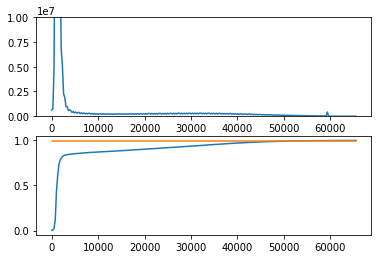

In [574]:
x = np.linspace(0, 2**16 - 1, 256)

h = np.zeros(256)
for file in tqdm(files):
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    h += np.histogram(img.ravel(), bins=256, range=(x[0], x[-1]))[0]

cdf = np.cumsum(h)
cdf = cdf / cdf.max()

diff = np.abs(cdf - 0.997)
idx = np.where(diff == diff.min())[0]

min_value = 0
max_value = x[idx][0]
print(max_value)

plt.subplot(211)
plt.plot(x, h)
plt.ylim([0, 1e7])
plt.subplot(212)
plt.plot(x, cdf)
plt.plot([x[0], x[-1]], [0.997, 0.997])
plt.show()

In [575]:
files_train, files_test = train_test_split(files, 
                                           test_size=0.10, 
                                           random_state=123)
len(files_train), len(files_test)

(810, 90)

In [576]:
train_dir = 'train'
test_dir = 'test'
class_dir = 'class_0'

os.makedirs(os.path.join(working_dir, train_dir, class_dir), 
            exist_ok=True)
os.makedirs(os.path.join(working_dir, test_dir, class_dir), 
            exist_ok=True)

for file in tqdm(files_train):
    input_path = os.path.join(working_dir, data_dir, file)
    output_path = os.path.join(working_dir, train_dir, class_dir, file)
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    img_normalized = (img-min_value)/(max_value-min_value)
    img_normalized = np.clip(img_normalized * 255, 0, 255)
    data = np.stack([img_normalized.astype(np.uint8), 
                     (seg * 255).astype(np.uint8)], axis=0)
    tifffile.imsave(output_path, data, compress=1)

for file in tqdm(files_test):
    input_path = os.path.join(working_dir, data_dir, file)
    output_path = os.path.join(working_dir, test_dir, class_dir, file)
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    img_normalized = np.clip((img-min_value)/(max_value-min_value) * 255, 0, 255)
    data = np.stack([img_normalized.astype(np.uint8), 
                     (seg * 255).astype(np.uint8)], axis=0)
    tifffile.imsave(output_path, data, compress=1)

# Make Dataloaders for segmentations

In [460]:
def load_tiff_seg(path):
    data = tifffile.imread(path)
    data = np.stack([data[0], data[1], np.zeros(data[0].shape, data.dtype)])
    return data.transpose((1, 2, 0))

In [461]:
import torch
from torch import nn
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jswaney/Pytorch-UNet/')
from unet.unet_model import UNet

In [577]:
data = load_tiff_seg(output_path)
data[0].shape, data[0].dtype

((570, 3), dtype('uint8'))

0.0


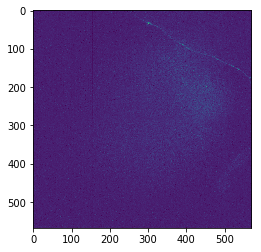

In [580]:
print(img.min())
plt.imshow(img)
plt.show()

In [581]:
degrees = 45
scale = (0.8, 1.2)
size = 256

dataset_train = DatasetFolder(os.path.join(working_dir, train_dir),
                              loader=load_tiff_seg,
                              extensions=['.tif'],
                              transform=transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomAffine(degrees, 
                                                          scale=scale),
                                  transforms.RandomCrop(size),
                                  transforms.ToTensor()]))
dataset_test = DatasetFolder(os.path.join(working_dir, test_dir),
                             loader=load_tiff_seg,
                             extensions=['.tif'],
                             transform=transforms.ToTensor())

print(dataset_train)
print(dataset_test)

Dataset DatasetFolder
    Number of datapoints: 5216
    Root Location: /media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation/train
    Transforms (if any): Compose(
                             ToPILImage()
                             RandomHorizontalFlip(p=0.5)
                             RandomAffine(degrees=(-45, 45), scale=(0.8, 1.2))
                             RandomCrop(size=(256, 256), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset DatasetFolder
    Number of datapoints: 580
    Root Location: /media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation/test
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [465]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [582]:
batch_size = 1
n_workers = 1 if use_cuda else 0
pin_memory = True if use_cuda else False

dataloader_train = DataLoader(dataset_train, 
                               batch_size, 
                               shuffle=True, 
                               num_workers=n_workers, 
                               pin_memory=pin_memory)

dataloader_test = DataLoader(dataset_test,
                               batch_size, 
                               num_workers=n_workers, 
                               pin_memory=pin_memory)

In [540]:
x, _ = next(iter(dataloader_train))
x.shape, x.dtype, x.max()

(torch.Size([1, 3, 256, 256]), torch.float32, tensor(1.))

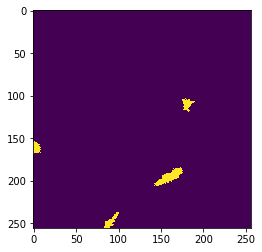

In [541]:
plt.imshow(x.numpy()[0, 1])
plt.show()

In [471]:
model = UNet(n_channels=1, n_classes=1)
model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [472]:
model = model.to(device)

In [615]:
optimizer = Adam(model.parameters(), lr=0.001)

In [474]:
model.train()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [616]:
def train_epoch(model, epoch, dataloader_train, device, optimizer, criterion, log_interval=100):
    model.train()
    n_batch = len(dataloader_train)
    epoch_loss = 0
    count = 0
    for batch_idx, (x, _) in enumerate(dataloader_train):
        img = x[:, 0].unsqueeze(1)
        img = img * (1 + np.random.random(1)[0])
        img = img.to(device)
        
        seg = x[:, 1].unsqueeze(1)
        seg = (seg > 0).type(torch.float).to(device)
        
        if seg.max() > 0:
            weight = torch.tensor([10], dtype=torch.float32).to(device)
        else:
            weight = torch.tensor([1], dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        output = model(img)
        
        output_flat = output.view(-1)
        seg_flat = seg.view(-1)
        criterion.weight = weight
        loss = criterion(output_flat, seg_flat)
        
        loss.backward()
        optimizer.step()
        
        count += len(x)
        epoch_loss += loss.item()
        ave_loss = epoch_loss / count
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(x)}/{len(dataloader_train.dataset)} ({100*batch_idx/n_batch:.0f}%)]\tLoss: {ave_loss}')
    

In [617]:
def test_epoch(model, dataloader_test, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, _ in dataloader_test:
            img = x[:, 0].unsqueeze(1).to(device)
            
            seg = x[:, 1].unsqueeze(1)
            seg = (seg > 0).type(torch.float).to(device)
            
            output = model(img)
            
            output_flat = output.view(-1)
            seg_flat = seg.view(-1)
            test_loss += criterion(output_flat, seg_flat)
    test_loss /= len(dataloader_test.dataset)
    print(f'Test set: Total loss: {test_loss:.4f}')

In [477]:
criterion = nn.BCELoss()

In [618]:
n_epochs = 200

for epoch in range(n_epochs):
    train_epoch(model, epoch, dataloader_train, device, optimizer, criterion)
    test_epoch(model, dataloader_test, criterion)

Train Epoch: 0 [0/5216 (0%)]	Loss: 0.00021577024017460644
Train Epoch: 0 [100/5216 (2%)]	Loss: 0.043213787076366986
Train Epoch: 0 [200/5216 (4%)]	Loss: 0.04202700428473675
Train Epoch: 0 [300/5216 (6%)]	Loss: 0.043710654015885184
Train Epoch: 0 [400/5216 (8%)]	Loss: 0.04350639930752824
Train Epoch: 0 [500/5216 (10%)]	Loss: 0.04577378319359735
Train Epoch: 0 [600/5216 (12%)]	Loss: 0.045885374668988885
Train Epoch: 0 [700/5216 (13%)]	Loss: 0.04374188566259769
Train Epoch: 0 [800/5216 (15%)]	Loss: 0.04420001682333744
Train Epoch: 0 [900/5216 (17%)]	Loss: 0.04528200698595158
Train Epoch: 0 [1000/5216 (19%)]	Loss: 0.046613316357230726
Train Epoch: 0 [1100/5216 (21%)]	Loss: 0.046169302445138935
Train Epoch: 0 [1200/5216 (23%)]	Loss: 0.04649135912361116
Train Epoch: 0 [1300/5216 (25%)]	Loss: 0.046490585375405284
Train Epoch: 0 [1400/5216 (27%)]	Loss: 0.046471831211321715
Train Epoch: 0 [1500/5216 (29%)]	Loss: 0.0465283009959398
Train Epoch: 0 [1600/5216 (31%)]	Loss: 0.04637691543306763
Train

Train Epoch: 2 [3300/5216 (63%)]	Loss: 0.04033323773241489
Train Epoch: 2 [3400/5216 (65%)]	Loss: 0.04020719037051686
Train Epoch: 2 [3500/5216 (67%)]	Loss: 0.04013321451032901
Train Epoch: 2 [3600/5216 (69%)]	Loss: 0.03988848664487093
Train Epoch: 2 [3700/5216 (71%)]	Loss: 0.039947867983547956
Train Epoch: 2 [3800/5216 (73%)]	Loss: 0.03992611738723511
Train Epoch: 2 [3900/5216 (75%)]	Loss: 0.03980633327076927
Train Epoch: 2 [4000/5216 (77%)]	Loss: 0.03984783577361305
Train Epoch: 2 [4100/5216 (79%)]	Loss: 0.039794061265007154
Train Epoch: 2 [4200/5216 (81%)]	Loss: 0.0399037344141157
Train Epoch: 2 [4300/5216 (82%)]	Loss: 0.039898572085783214
Train Epoch: 2 [4400/5216 (84%)]	Loss: 0.040062622587917165
Train Epoch: 2 [4500/5216 (86%)]	Loss: 0.04008436654872408
Train Epoch: 2 [4600/5216 (88%)]	Loss: 0.040174024968169915
Train Epoch: 2 [4700/5216 (90%)]	Loss: 0.04000370576544715
Train Epoch: 2 [4800/5216 (92%)]	Loss: 0.04019665381074308
Train Epoch: 2 [4900/5216 (94%)]	Loss: 0.04034571185

Train Epoch: 5 [1200/5216 (23%)]	Loss: 0.035829933854690674
Train Epoch: 5 [1300/5216 (25%)]	Loss: 0.03697690527177692
Train Epoch: 5 [1400/5216 (27%)]	Loss: 0.03686850078713811
Train Epoch: 5 [1500/5216 (29%)]	Loss: 0.0376837996214034
Train Epoch: 5 [1600/5216 (31%)]	Loss: 0.03771757460437001
Train Epoch: 5 [1700/5216 (33%)]	Loss: 0.03872064166407375
Train Epoch: 5 [1800/5216 (35%)]	Loss: 0.03893663660628238
Train Epoch: 5 [1900/5216 (36%)]	Loss: 0.038801015131172234
Train Epoch: 5 [2000/5216 (38%)]	Loss: 0.039289872240621256
Train Epoch: 5 [2100/5216 (40%)]	Loss: 0.03916165682515391
Train Epoch: 5 [2200/5216 (42%)]	Loss: 0.038699426720968884
Train Epoch: 5 [2300/5216 (44%)]	Loss: 0.03948768779598573
Train Epoch: 5 [2400/5216 (46%)]	Loss: 0.03951431649693376
Train Epoch: 5 [2500/5216 (48%)]	Loss: 0.03910290318510953
Train Epoch: 5 [2600/5216 (50%)]	Loss: 0.03870423790093035
Train Epoch: 5 [2700/5216 (52%)]	Loss: 0.038436920122451125
Train Epoch: 5 [2800/5216 (54%)]	Loss: 0.03852224883

Train Epoch: 7 [4400/5216 (84%)]	Loss: 0.0381029669700488
Train Epoch: 7 [4500/5216 (86%)]	Loss: 0.03831969031741458
Train Epoch: 7 [4600/5216 (88%)]	Loss: 0.03818091952068775
Train Epoch: 7 [4700/5216 (90%)]	Loss: 0.03819838366616349
Train Epoch: 7 [4800/5216 (92%)]	Loss: 0.03823114874982262
Train Epoch: 7 [4900/5216 (94%)]	Loss: 0.0382870242160496
Train Epoch: 7 [5000/5216 (96%)]	Loss: 0.038655397208858355
Train Epoch: 7 [5100/5216 (98%)]	Loss: 0.03883195220321263
Train Epoch: 7 [5200/5216 (100%)]	Loss: 0.03854599273206472
Test set: Total loss: 0.2671
Train Epoch: 8 [0/5216 (0%)]	Loss: 1.8032682419288903e-05
Train Epoch: 8 [100/5216 (2%)]	Loss: 0.03620092281436099
Train Epoch: 8 [200/5216 (4%)]	Loss: 0.0378418314688476
Train Epoch: 8 [300/5216 (6%)]	Loss: 0.04046997246236962
Train Epoch: 8 [400/5216 (8%)]	Loss: 0.042162773993868426
Train Epoch: 8 [500/5216 (10%)]	Loss: 0.04031358926262984
Train Epoch: 8 [600/5216 (12%)]	Loss: 0.03888369779869252
Train Epoch: 8 [700/5216 (13%)]	Loss: 

Train Epoch: 10 [2300/5216 (44%)]	Loss: 0.03694169977520923
Train Epoch: 10 [2400/5216 (46%)]	Loss: 0.036575061184105126
Train Epoch: 10 [2500/5216 (48%)]	Loss: 0.03658333220151358
Train Epoch: 10 [2600/5216 (50%)]	Loss: 0.036738160292375296
Train Epoch: 10 [2700/5216 (52%)]	Loss: 0.03674976246217931
Train Epoch: 10 [2800/5216 (54%)]	Loss: 0.037026422514883015
Train Epoch: 10 [2900/5216 (56%)]	Loss: 0.037415981400612246
Train Epoch: 10 [3000/5216 (58%)]	Loss: 0.03759901923383516
Train Epoch: 10 [3100/5216 (59%)]	Loss: 0.037572708156072845
Train Epoch: 10 [3200/5216 (61%)]	Loss: 0.03805383804718133
Train Epoch: 10 [3300/5216 (63%)]	Loss: 0.038155644384810054
Train Epoch: 10 [3400/5216 (65%)]	Loss: 0.03825720707036808
Train Epoch: 10 [3500/5216 (67%)]	Loss: 0.03820806176050913
Train Epoch: 10 [3600/5216 (69%)]	Loss: 0.038118235359314384
Train Epoch: 10 [3700/5216 (71%)]	Loss: 0.03798386913076276
Train Epoch: 10 [3800/5216 (73%)]	Loss: 0.037917984560342594
Train Epoch: 10 [3900/5216 (75%)

Test set: Total loss: 0.0264
Train Epoch: 13 [0/5216 (0%)]	Loss: 0.055636029690504074
Train Epoch: 13 [100/5216 (2%)]	Loss: 0.0394284938967734
Train Epoch: 13 [200/5216 (4%)]	Loss: 0.041611189047036465
Train Epoch: 13 [300/5216 (6%)]	Loss: 0.040096850975090394
Train Epoch: 13 [400/5216 (8%)]	Loss: 0.036586414150896245
Train Epoch: 13 [500/5216 (10%)]	Loss: 0.03620779700861964
Train Epoch: 13 [600/5216 (12%)]	Loss: 0.03657893017888458
Train Epoch: 13 [700/5216 (13%)]	Loss: 0.03658118638580556
Train Epoch: 13 [800/5216 (15%)]	Loss: 0.03741105039147663
Train Epoch: 13 [900/5216 (17%)]	Loss: 0.03820859459339484
Train Epoch: 13 [1000/5216 (19%)]	Loss: 0.03696081471073118
Train Epoch: 13 [1100/5216 (21%)]	Loss: 0.036575829401520515
Train Epoch: 13 [1200/5216 (23%)]	Loss: 0.037125926255068886
Train Epoch: 13 [1300/5216 (25%)]	Loss: 0.03683464313958254
Train Epoch: 13 [1400/5216 (27%)]	Loss: 0.036576318665562546
Train Epoch: 13 [1500/5216 (29%)]	Loss: 0.03662619646005731
Train Epoch: 13 [1600/

Train Epoch: 15 [3000/5216 (58%)]	Loss: 0.03831304466140763
Train Epoch: 15 [3100/5216 (59%)]	Loss: 0.03814192752514899
Train Epoch: 15 [3200/5216 (61%)]	Loss: 0.038122317865845856
Train Epoch: 15 [3300/5216 (63%)]	Loss: 0.037892844900053124
Train Epoch: 15 [3400/5216 (65%)]	Loss: 0.037909408678530224
Train Epoch: 15 [3500/5216 (67%)]	Loss: 0.03771217600547795
Train Epoch: 15 [3600/5216 (69%)]	Loss: 0.037860076739775934
Train Epoch: 15 [3700/5216 (71%)]	Loss: 0.03816717303867047
Train Epoch: 15 [3800/5216 (73%)]	Loss: 0.03820417294071553
Train Epoch: 15 [3900/5216 (75%)]	Loss: 0.03835555828895909
Train Epoch: 15 [4000/5216 (77%)]	Loss: 0.03848460907067937
Train Epoch: 15 [4100/5216 (79%)]	Loss: 0.03829288357202946
Train Epoch: 15 [4200/5216 (81%)]	Loss: 0.0381777815187296
Train Epoch: 15 [4300/5216 (82%)]	Loss: 0.03853981131437383
Train Epoch: 15 [4400/5216 (84%)]	Loss: 0.038638681895183775
Train Epoch: 15 [4500/5216 (86%)]	Loss: 0.03869835960162149
Train Epoch: 15 [4600/5216 (88%)]	Lo

Train Epoch: 18 [700/5216 (13%)]	Loss: 0.03689386522536193
Train Epoch: 18 [800/5216 (15%)]	Loss: 0.03779152769978401
Train Epoch: 18 [900/5216 (17%)]	Loss: 0.03707417325986572
Train Epoch: 18 [1000/5216 (19%)]	Loss: 0.03814258100535685
Train Epoch: 18 [1100/5216 (21%)]	Loss: 0.03730262167960817
Train Epoch: 18 [1200/5216 (23%)]	Loss: 0.03721088772679756
Train Epoch: 18 [1300/5216 (25%)]	Loss: 0.03724306766640132
Train Epoch: 18 [1400/5216 (27%)]	Loss: 0.03708590484644365
Train Epoch: 18 [1500/5216 (29%)]	Loss: 0.03662246960110464
Train Epoch: 18 [1600/5216 (31%)]	Loss: 0.036232906317833935
Train Epoch: 18 [1700/5216 (33%)]	Loss: 0.036890400699867744
Train Epoch: 18 [1800/5216 (35%)]	Loss: 0.03668850287529661
Train Epoch: 18 [1900/5216 (36%)]	Loss: 0.036226261744569915
Train Epoch: 18 [2000/5216 (38%)]	Loss: 0.03625886222794251
Train Epoch: 18 [2100/5216 (40%)]	Loss: 0.03617828768691131
Train Epoch: 18 [2200/5216 (42%)]	Loss: 0.036018172324487514
Train Epoch: 18 [2300/5216 (44%)]	Loss:

Train Epoch: 20 [3700/5216 (71%)]	Loss: 0.03920839118597943
Train Epoch: 20 [3800/5216 (73%)]	Loss: 0.03964942245491414
Train Epoch: 20 [3900/5216 (75%)]	Loss: 0.03955299442304454
Train Epoch: 20 [4000/5216 (77%)]	Loss: 0.03923373271194702
Train Epoch: 20 [4100/5216 (79%)]	Loss: 0.03909586455213882
Train Epoch: 20 [4200/5216 (81%)]	Loss: 0.038996632202902407
Train Epoch: 20 [4300/5216 (82%)]	Loss: 0.039398413522152
Train Epoch: 20 [4400/5216 (84%)]	Loss: 0.03959254508810012
Train Epoch: 20 [4500/5216 (86%)]	Loss: 0.0395923813770268
Train Epoch: 20 [4600/5216 (88%)]	Loss: 0.039388455773420226
Train Epoch: 20 [4700/5216 (90%)]	Loss: 0.03941571790184542
Train Epoch: 20 [4800/5216 (92%)]	Loss: 0.03927578239978563
Train Epoch: 20 [4900/5216 (94%)]	Loss: 0.03931038652433828
Train Epoch: 20 [5000/5216 (96%)]	Loss: 0.039269850813445174
Train Epoch: 20 [5100/5216 (98%)]	Loss: 0.03932072573664751
Train Epoch: 20 [5200/5216 (100%)]	Loss: 0.03924372897715494
Test set: Total loss: 0.2301
Train Epoc

Train Epoch: 23 [1400/5216 (27%)]	Loss: 0.040411946359026236
Train Epoch: 23 [1500/5216 (29%)]	Loss: 0.04045067705002844
Train Epoch: 23 [1600/5216 (31%)]	Loss: 0.03962597227698021
Train Epoch: 23 [1700/5216 (33%)]	Loss: 0.03885576607951129
Train Epoch: 23 [1800/5216 (35%)]	Loss: 0.03790807976865038
Train Epoch: 23 [1900/5216 (36%)]	Loss: 0.03797838029396551
Train Epoch: 23 [2000/5216 (38%)]	Loss: 0.038042033931900504
Train Epoch: 23 [2100/5216 (40%)]	Loss: 0.038076287896735124
Train Epoch: 23 [2200/5216 (42%)]	Loss: 0.03832443059633608
Train Epoch: 23 [2300/5216 (44%)]	Loss: 0.03848090347559892
Train Epoch: 23 [2400/5216 (46%)]	Loss: 0.03895440880042251
Train Epoch: 23 [2500/5216 (48%)]	Loss: 0.03852209327594999
Train Epoch: 23 [2600/5216 (50%)]	Loss: 0.0382906497911889
Train Epoch: 23 [2700/5216 (52%)]	Loss: 0.03825489121856612
Train Epoch: 23 [2800/5216 (54%)]	Loss: 0.038001871557157764
Train Epoch: 23 [2900/5216 (56%)]	Loss: 0.037963097339923924
Train Epoch: 23 [3000/5216 (58%)]	Lo

Train Epoch: 25 [4400/5216 (84%)]	Loss: 0.03756467746176079
Train Epoch: 25 [4500/5216 (86%)]	Loss: 0.03746545408321576
Train Epoch: 25 [4600/5216 (88%)]	Loss: 0.03742672784087754
Train Epoch: 25 [4700/5216 (90%)]	Loss: 0.03753496954476441
Train Epoch: 25 [4800/5216 (92%)]	Loss: 0.0372715825274618
Train Epoch: 25 [4900/5216 (94%)]	Loss: 0.03713910337391847
Train Epoch: 25 [5000/5216 (96%)]	Loss: 0.03701549602617701
Train Epoch: 25 [5100/5216 (98%)]	Loss: 0.037088072994216056
Train Epoch: 25 [5200/5216 (100%)]	Loss: 0.036919466556858946
Test set: Total loss: 0.2523
Train Epoch: 26 [0/5216 (0%)]	Loss: 1.3781125289824558e-06
Train Epoch: 26 [100/5216 (2%)]	Loss: 0.0356442017430952
Train Epoch: 26 [200/5216 (4%)]	Loss: 0.035332315812578674
Train Epoch: 26 [300/5216 (6%)]	Loss: 0.03389447909952359
Train Epoch: 26 [400/5216 (8%)]	Loss: 0.03517860092931347
Train Epoch: 26 [500/5216 (10%)]	Loss: 0.03535688558171243
Train Epoch: 26 [600/5216 (12%)]	Loss: 0.036192568892266
Train Epoch: 26 [700/5

Train Epoch: 28 [2100/5216 (40%)]	Loss: 0.0380673073123689
Train Epoch: 28 [2200/5216 (42%)]	Loss: 0.03788642704067583
Train Epoch: 28 [2300/5216 (44%)]	Loss: 0.038133820245079615
Train Epoch: 28 [2400/5216 (46%)]	Loss: 0.037738614710026416
Train Epoch: 28 [2500/5216 (48%)]	Loss: 0.038034649646682336
Train Epoch: 28 [2600/5216 (50%)]	Loss: 0.03773017664362765
Train Epoch: 28 [2700/5216 (52%)]	Loss: 0.0380210359717158
Train Epoch: 28 [2800/5216 (54%)]	Loss: 0.03776104633363092
Train Epoch: 28 [2900/5216 (56%)]	Loss: 0.03795918577339866
Train Epoch: 28 [3000/5216 (58%)]	Loss: 0.03830520442092655
Train Epoch: 28 [3100/5216 (59%)]	Loss: 0.03806659315756061
Train Epoch: 28 [3200/5216 (61%)]	Loss: 0.0379103744519918
Train Epoch: 28 [3300/5216 (63%)]	Loss: 0.037653818098439276
Train Epoch: 28 [3400/5216 (65%)]	Loss: 0.03762500246535956
Train Epoch: 28 [3500/5216 (67%)]	Loss: 0.03749721939082271
Train Epoch: 28 [3600/5216 (69%)]	Loss: 0.0372701262729904
Train Epoch: 28 [3700/5216 (71%)]	Loss: 

Train Epoch: 30 [5100/5216 (98%)]	Loss: 0.037728802455952955
Train Epoch: 30 [5200/5216 (100%)]	Loss: 0.03767642176239112
Test set: Total loss: 0.0275
Train Epoch: 31 [0/5216 (0%)]	Loss: 0.004495888017117977
Train Epoch: 31 [100/5216 (2%)]	Loss: 0.043194417061335394
Train Epoch: 31 [200/5216 (4%)]	Loss: 0.040194395210243275
Train Epoch: 31 [300/5216 (6%)]	Loss: 0.03566878338251037
Train Epoch: 31 [400/5216 (8%)]	Loss: 0.03684245825333359
Train Epoch: 31 [500/5216 (10%)]	Loss: 0.03894660557309199
Train Epoch: 31 [600/5216 (12%)]	Loss: 0.03860096024625125
Train Epoch: 31 [700/5216 (13%)]	Loss: 0.03890967471143757
Train Epoch: 31 [800/5216 (15%)]	Loss: 0.03932135860155315
Train Epoch: 31 [900/5216 (17%)]	Loss: 0.037951073793065074
Train Epoch: 31 [1000/5216 (19%)]	Loss: 0.038912761616246315
Train Epoch: 31 [1100/5216 (21%)]	Loss: 0.0386953428109485
Train Epoch: 31 [1200/5216 (23%)]	Loss: 0.03838124791663265
Train Epoch: 31 [1300/5216 (25%)]	Loss: 0.03839259055481393
Train Epoch: 31 [1400/

Train Epoch: 33 [2800/5216 (54%)]	Loss: 0.03596857551917927
Train Epoch: 33 [2900/5216 (56%)]	Loss: 0.03614499081975155
Train Epoch: 33 [3000/5216 (58%)]	Loss: 0.036466398880632106
Train Epoch: 33 [3100/5216 (59%)]	Loss: 0.036679367769597
Train Epoch: 33 [3200/5216 (61%)]	Loss: 0.036498183733469594
Train Epoch: 33 [3300/5216 (63%)]	Loss: 0.03647019258574718
Train Epoch: 33 [3400/5216 (65%)]	Loss: 0.0364071860580654
Train Epoch: 33 [3500/5216 (67%)]	Loss: 0.03668612337037879
Train Epoch: 33 [3600/5216 (69%)]	Loss: 0.03689916826912106
Train Epoch: 33 [3700/5216 (71%)]	Loss: 0.036637083824654505
Train Epoch: 33 [3800/5216 (73%)]	Loss: 0.03658810026044897
Train Epoch: 33 [3900/5216 (75%)]	Loss: 0.036525917847868704
Train Epoch: 33 [4000/5216 (77%)]	Loss: 0.03682907795238028
Train Epoch: 33 [4100/5216 (79%)]	Loss: 0.037258656697580335
Train Epoch: 33 [4200/5216 (81%)]	Loss: 0.03721231999320421
Train Epoch: 33 [4300/5216 (82%)]	Loss: 0.03701190527722952
Train Epoch: 33 [4400/5216 (84%)]	Loss

Train Epoch: 36 [500/5216 (10%)]	Loss: 0.03334607590005113
Train Epoch: 36 [600/5216 (12%)]	Loss: 0.03321368124157197
Train Epoch: 36 [700/5216 (13%)]	Loss: 0.03341181474916304
Train Epoch: 36 [800/5216 (15%)]	Loss: 0.033288304027728095
Train Epoch: 36 [900/5216 (17%)]	Loss: 0.033535395811071345
Train Epoch: 36 [1000/5216 (19%)]	Loss: 0.035127829232941145
Train Epoch: 36 [1100/5216 (21%)]	Loss: 0.034883786206604546
Train Epoch: 36 [1200/5216 (23%)]	Loss: 0.03477431187356462
Train Epoch: 36 [1300/5216 (25%)]	Loss: 0.035686093960515565
Train Epoch: 36 [1400/5216 (27%)]	Loss: 0.03493074204924061
Train Epoch: 36 [1500/5216 (29%)]	Loss: 0.03464996382826177
Train Epoch: 36 [1600/5216 (31%)]	Loss: 0.03410349554784575
Train Epoch: 36 [1700/5216 (33%)]	Loss: 0.03426231733835349
Train Epoch: 36 [1800/5216 (35%)]	Loss: 0.03460057364202091
Train Epoch: 36 [1900/5216 (36%)]	Loss: 0.03528479449152318
Train Epoch: 36 [2000/5216 (38%)]	Loss: 0.035148295581391806
Train Epoch: 36 [2100/5216 (40%)]	Loss:

Train Epoch: 38 [3500/5216 (67%)]	Loss: 0.03706250252461324
Train Epoch: 38 [3600/5216 (69%)]	Loss: 0.037192325664438336
Train Epoch: 38 [3700/5216 (71%)]	Loss: 0.0369550485727906
Train Epoch: 38 [3800/5216 (73%)]	Loss: 0.03700619087393575
Train Epoch: 38 [3900/5216 (75%)]	Loss: 0.03744621952564572
Train Epoch: 38 [4000/5216 (77%)]	Loss: 0.03730738636105582
Train Epoch: 38 [4100/5216 (79%)]	Loss: 0.03723955519882596
Train Epoch: 38 [4200/5216 (81%)]	Loss: 0.03739154865488579
Train Epoch: 38 [4300/5216 (82%)]	Loss: 0.03753260482761966
Train Epoch: 38 [4400/5216 (84%)]	Loss: 0.03743712539597801
Train Epoch: 38 [4500/5216 (86%)]	Loss: 0.037217692155689576
Train Epoch: 38 [4600/5216 (88%)]	Loss: 0.03736562590525092
Train Epoch: 38 [4700/5216 (90%)]	Loss: 0.037381041574592384
Train Epoch: 38 [4800/5216 (92%)]	Loss: 0.03718698010160831
Train Epoch: 38 [4900/5216 (94%)]	Loss: 0.03696387005392621
Train Epoch: 38 [5000/5216 (96%)]	Loss: 0.03696191711280451
Train Epoch: 38 [5100/5216 (98%)]	Loss

Train Epoch: 41 [1200/5216 (23%)]	Loss: 0.039074428789359406
Train Epoch: 41 [1300/5216 (25%)]	Loss: 0.03889929391357205
Train Epoch: 41 [1400/5216 (27%)]	Loss: 0.038087880732513214
Train Epoch: 41 [1500/5216 (29%)]	Loss: 0.038411267261255724
Train Epoch: 41 [1600/5216 (31%)]	Loss: 0.038744206871882285
Train Epoch: 41 [1700/5216 (33%)]	Loss: 0.03797751294874132
Train Epoch: 41 [1800/5216 (35%)]	Loss: 0.038460750944519444
Train Epoch: 41 [1900/5216 (36%)]	Loss: 0.03840040088790586
Train Epoch: 41 [2000/5216 (38%)]	Loss: 0.0386551588070495
Train Epoch: 41 [2100/5216 (40%)]	Loss: 0.038081452177955756
Train Epoch: 41 [2200/5216 (42%)]	Loss: 0.03786852801770215
Train Epoch: 41 [2300/5216 (44%)]	Loss: 0.037845795549297095
Train Epoch: 41 [2400/5216 (46%)]	Loss: 0.037969511956171646
Train Epoch: 41 [2500/5216 (48%)]	Loss: 0.037799679718806635
Train Epoch: 41 [2600/5216 (50%)]	Loss: 0.038263620149326764
Train Epoch: 41 [2700/5216 (52%)]	Loss: 0.03813893441062973
Train Epoch: 41 [2800/5216 (54%

Train Epoch: 43 [4200/5216 (81%)]	Loss: 0.03720020180143647
Train Epoch: 43 [4300/5216 (82%)]	Loss: 0.03713908575292899
Train Epoch: 43 [4400/5216 (84%)]	Loss: 0.03713371502829304
Train Epoch: 43 [4500/5216 (86%)]	Loss: 0.03727540934471273
Train Epoch: 43 [4600/5216 (88%)]	Loss: 0.03752927655731983
Train Epoch: 43 [4700/5216 (90%)]	Loss: 0.03736801765458616
Train Epoch: 43 [4800/5216 (92%)]	Loss: 0.037559449850296724
Train Epoch: 43 [4900/5216 (94%)]	Loss: 0.03746581327329038
Train Epoch: 43 [5000/5216 (96%)]	Loss: 0.03743975657930691
Train Epoch: 43 [5100/5216 (98%)]	Loss: 0.03733629030649981
Train Epoch: 43 [5200/5216 (100%)]	Loss: 0.03731074485274206
Test set: Total loss: 0.0262
Train Epoch: 44 [0/5216 (0%)]	Loss: 0.05162164196372032
Train Epoch: 44 [100/5216 (2%)]	Loss: 0.03746311864966349
Train Epoch: 44 [200/5216 (4%)]	Loss: 0.03753297034168088
Train Epoch: 44 [300/5216 (6%)]	Loss: 0.037970312187553645
Train Epoch: 44 [400/5216 (8%)]	Loss: 0.037647879484730265
Train Epoch: 44 [50

Train Epoch: 46 [1900/5216 (36%)]	Loss: 0.03698333596235557
Train Epoch: 46 [2000/5216 (38%)]	Loss: 0.03696233948734882
Train Epoch: 46 [2100/5216 (40%)]	Loss: 0.03726610816948859
Train Epoch: 46 [2200/5216 (42%)]	Loss: 0.036949159465112846
Train Epoch: 46 [2300/5216 (44%)]	Loss: 0.036994441927923956
Train Epoch: 46 [2400/5216 (46%)]	Loss: 0.03672145631316321
Train Epoch: 46 [2500/5216 (48%)]	Loss: 0.036872518051439374
Train Epoch: 46 [2600/5216 (50%)]	Loss: 0.03690543688996153
Train Epoch: 46 [2700/5216 (52%)]	Loss: 0.036940020574561645
Train Epoch: 46 [2800/5216 (54%)]	Loss: 0.03662737456916955
Train Epoch: 46 [2900/5216 (56%)]	Loss: 0.036606548583715
Train Epoch: 46 [3000/5216 (58%)]	Loss: 0.0364265980034105
Train Epoch: 46 [3100/5216 (59%)]	Loss: 0.036278764879164066
Train Epoch: 46 [3200/5216 (61%)]	Loss: 0.036082537368663896
Train Epoch: 46 [3300/5216 (63%)]	Loss: 0.03616368639155584
Train Epoch: 46 [3400/5216 (65%)]	Loss: 0.03650893360442629
Train Epoch: 46 [3500/5216 (67%)]	Los

Train Epoch: 48 [4900/5216 (94%)]	Loss: 0.036109218900376466
Train Epoch: 48 [5000/5216 (96%)]	Loss: 0.036207747627151864
Train Epoch: 48 [5100/5216 (98%)]	Loss: 0.036172756672128145
Train Epoch: 48 [5200/5216 (100%)]	Loss: 0.03621046177971041
Test set: Total loss: 0.2252
Train Epoch: 49 [0/5216 (0%)]	Loss: 0.0007276094984263182
Train Epoch: 49 [100/5216 (2%)]	Loss: 0.02666450927598803
Train Epoch: 49 [200/5216 (4%)]	Loss: 0.025575788639859223
Train Epoch: 49 [300/5216 (6%)]	Loss: 0.027933020465133587
Train Epoch: 49 [400/5216 (8%)]	Loss: 0.031061117232879916
Train Epoch: 49 [500/5216 (10%)]	Loss: 0.0293560663256949
Train Epoch: 49 [600/5216 (12%)]	Loss: 0.031115170747679888
Train Epoch: 49 [700/5216 (13%)]	Loss: 0.03236155750541243
Train Epoch: 49 [800/5216 (15%)]	Loss: 0.03361089367245619
Train Epoch: 49 [900/5216 (17%)]	Loss: 0.033716139739457654
Train Epoch: 49 [1000/5216 (19%)]	Loss: 0.0333130975558615
Train Epoch: 49 [1100/5216 (21%)]	Loss: 0.033988529103286334
Train Epoch: 49 [1

Train Epoch: 51 [2600/5216 (50%)]	Loss: 0.03579782761219262
Train Epoch: 51 [2700/5216 (52%)]	Loss: 0.03615839566169652
Train Epoch: 51 [2800/5216 (54%)]	Loss: 0.03601427037016164
Train Epoch: 51 [2900/5216 (56%)]	Loss: 0.03589627203144761
Train Epoch: 51 [3000/5216 (58%)]	Loss: 0.036112466101912495
Train Epoch: 51 [3100/5216 (59%)]	Loss: 0.03597974259652024
Train Epoch: 51 [3200/5216 (61%)]	Loss: 0.03581821026628961
Train Epoch: 51 [3300/5216 (63%)]	Loss: 0.03588222453124036
Train Epoch: 51 [3400/5216 (65%)]	Loss: 0.03598639340332119
Train Epoch: 51 [3500/5216 (67%)]	Loss: 0.03657522704080068
Train Epoch: 51 [3600/5216 (69%)]	Loss: 0.03681444029096143
Train Epoch: 51 [3700/5216 (71%)]	Loss: 0.037008676463714835
Train Epoch: 51 [3800/5216 (73%)]	Loss: 0.03708013772854302
Train Epoch: 51 [3900/5216 (75%)]	Loss: 0.037034973108622325
Train Epoch: 51 [4000/5216 (77%)]	Loss: 0.037367335344587985
Train Epoch: 51 [4100/5216 (79%)]	Loss: 0.03727513655360101
Train Epoch: 51 [4200/5216 (81%)]	Lo

Train Epoch: 54 [300/5216 (6%)]	Loss: 0.031814152835271524
Train Epoch: 54 [400/5216 (8%)]	Loss: 0.03370670460567209
Train Epoch: 54 [500/5216 (10%)]	Loss: 0.03416287543335445
Train Epoch: 54 [600/5216 (12%)]	Loss: 0.034878798346155385
Train Epoch: 54 [700/5216 (13%)]	Loss: 0.03480852074647123
Train Epoch: 54 [800/5216 (15%)]	Loss: 0.03615637861275772
Train Epoch: 54 [900/5216 (17%)]	Loss: 0.03607724877521313
Train Epoch: 54 [1000/5216 (19%)]	Loss: 0.03655259680604045
Train Epoch: 54 [1100/5216 (21%)]	Loss: 0.036485285598167994
Train Epoch: 54 [1200/5216 (23%)]	Loss: 0.03550756232584642
Train Epoch: 54 [1300/5216 (25%)]	Loss: 0.03542329225409827
Train Epoch: 54 [1400/5216 (27%)]	Loss: 0.03617452804585008
Train Epoch: 54 [1500/5216 (29%)]	Loss: 0.03751190844216809
Train Epoch: 54 [1600/5216 (31%)]	Loss: 0.03709399475999091
Train Epoch: 54 [1700/5216 (33%)]	Loss: 0.03699407749803049
Train Epoch: 54 [1800/5216 (35%)]	Loss: 0.03652889546808159
Train Epoch: 54 [1900/5216 (36%)]	Loss: 0.0359

Train Epoch: 56 [3300/5216 (63%)]	Loss: 0.03559232670408647
Train Epoch: 56 [3400/5216 (65%)]	Loss: 0.0358950647662666
Train Epoch: 56 [3500/5216 (67%)]	Loss: 0.03600301066377996
Train Epoch: 56 [3600/5216 (69%)]	Loss: 0.03621015211100466
Train Epoch: 56 [3700/5216 (71%)]	Loss: 0.03611973397874886
Train Epoch: 56 [3800/5216 (73%)]	Loss: 0.03638737363710968
Train Epoch: 56 [3900/5216 (75%)]	Loss: 0.03658334575871366
Train Epoch: 56 [4000/5216 (77%)]	Loss: 0.036541719680746806
Train Epoch: 56 [4100/5216 (79%)]	Loss: 0.036505281237522655
Train Epoch: 56 [4200/5216 (81%)]	Loss: 0.036447602251294696
Train Epoch: 56 [4300/5216 (82%)]	Loss: 0.036416452506535926
Train Epoch: 56 [4400/5216 (84%)]	Loss: 0.03617320323050439
Train Epoch: 56 [4500/5216 (86%)]	Loss: 0.03606812335643498
Train Epoch: 56 [4600/5216 (88%)]	Loss: 0.03602729890045947
Train Epoch: 56 [4700/5216 (90%)]	Loss: 0.036027012277533625
Train Epoch: 56 [4800/5216 (92%)]	Loss: 0.03594125391149541
Train Epoch: 56 [4900/5216 (94%)]	Lo

Train Epoch: 59 [1000/5216 (19%)]	Loss: 0.039086471458462314
Train Epoch: 59 [1100/5216 (21%)]	Loss: 0.040049104938355735
Train Epoch: 59 [1200/5216 (23%)]	Loss: 0.040277518955522944
Train Epoch: 59 [1300/5216 (25%)]	Loss: 0.040489910087612775
Train Epoch: 59 [1400/5216 (27%)]	Loss: 0.04010498102413183
Train Epoch: 59 [1500/5216 (29%)]	Loss: 0.039445391543944504
Train Epoch: 59 [1600/5216 (31%)]	Loss: 0.03914913760569168
Train Epoch: 59 [1700/5216 (33%)]	Loss: 0.038644629477357764
Train Epoch: 59 [1800/5216 (35%)]	Loss: 0.03847968090302838
Train Epoch: 59 [1900/5216 (36%)]	Loss: 0.03808211620109989
Train Epoch: 59 [2000/5216 (38%)]	Loss: 0.03817763457059537
Train Epoch: 59 [2100/5216 (40%)]	Loss: 0.037605263023873035
Train Epoch: 59 [2200/5216 (42%)]	Loss: 0.03728510464877611
Train Epoch: 59 [2300/5216 (44%)]	Loss: 0.037450354328120675
Train Epoch: 59 [2400/5216 (46%)]	Loss: 0.03776701448129782
Train Epoch: 59 [2500/5216 (48%)]	Loss: 0.037526381780779744
Train Epoch: 59 [2600/5216 (50%

Train Epoch: 61 [4000/5216 (77%)]	Loss: 0.03578405940334163
Train Epoch: 61 [4100/5216 (79%)]	Loss: 0.035802506765689905
Train Epoch: 61 [4200/5216 (81%)]	Loss: 0.035936994080315914
Train Epoch: 61 [4300/5216 (82%)]	Loss: 0.03595083279413778
Train Epoch: 61 [4400/5216 (84%)]	Loss: 0.035794581267144535
Train Epoch: 61 [4500/5216 (86%)]	Loss: 0.0357415545921622
Train Epoch: 61 [4600/5216 (88%)]	Loss: 0.03559453598302219
Train Epoch: 61 [4700/5216 (90%)]	Loss: 0.03560401260088342
Train Epoch: 61 [4800/5216 (92%)]	Loss: 0.03555933420258551
Train Epoch: 61 [4900/5216 (94%)]	Loss: 0.035749742436000743
Train Epoch: 61 [5000/5216 (96%)]	Loss: 0.03560938736777817
Train Epoch: 61 [5100/5216 (98%)]	Loss: 0.03553000916816659
Train Epoch: 61 [5200/5216 (100%)]	Loss: 0.03558110673569453
Test set: Total loss: 0.0246
Train Epoch: 62 [0/5216 (0%)]	Loss: 4.6461473175440915e-06
Train Epoch: 62 [100/5216 (2%)]	Loss: 0.03788283155331263
Train Epoch: 62 [200/5216 (4%)]	Loss: 0.04022505330339672
Train Epoch:

Train Epoch: 64 [1700/5216 (33%)]	Loss: 0.03429882853861024
Train Epoch: 64 [1800/5216 (35%)]	Loss: 0.03399583944775081
Train Epoch: 64 [1900/5216 (36%)]	Loss: 0.03425752398714018
Train Epoch: 64 [2000/5216 (38%)]	Loss: 0.03518373988157944
Train Epoch: 64 [2100/5216 (40%)]	Loss: 0.03529623870061272
Train Epoch: 64 [2200/5216 (42%)]	Loss: 0.035221919169616256
Train Epoch: 64 [2300/5216 (44%)]	Loss: 0.0350336549636704
Train Epoch: 64 [2400/5216 (46%)]	Loss: 0.034936014465234595
Train Epoch: 64 [2500/5216 (48%)]	Loss: 0.03504487691305425
Train Epoch: 64 [2600/5216 (50%)]	Loss: 0.03489691082097105
Train Epoch: 64 [2700/5216 (52%)]	Loss: 0.03513408437135689
Train Epoch: 64 [2800/5216 (54%)]	Loss: 0.03529981507654865
Train Epoch: 64 [2900/5216 (56%)]	Loss: 0.0356288230071593
Train Epoch: 64 [3000/5216 (58%)]	Loss: 0.035075776887513045
Train Epoch: 64 [3100/5216 (59%)]	Loss: 0.035125134684220224
Train Epoch: 64 [3200/5216 (61%)]	Loss: 0.034952231647219265
Train Epoch: 64 [3300/5216 (63%)]	Los

Train Epoch: 66 [4700/5216 (90%)]	Loss: 0.03690278013834161
Train Epoch: 66 [4800/5216 (92%)]	Loss: 0.036590886754308036
Train Epoch: 66 [4900/5216 (94%)]	Loss: 0.036427865790166464
Train Epoch: 66 [5000/5216 (96%)]	Loss: 0.03654736856162258
Train Epoch: 66 [5100/5216 (98%)]	Loss: 0.03669744752756407
Train Epoch: 66 [5200/5216 (100%)]	Loss: 0.036559997534913215
Test set: Total loss: 0.0268
Train Epoch: 67 [0/5216 (0%)]	Loss: 5.077712899037579e-07
Train Epoch: 67 [100/5216 (2%)]	Loss: 0.0329205128512252
Train Epoch: 67 [200/5216 (4%)]	Loss: 0.03496061571802278
Train Epoch: 67 [300/5216 (6%)]	Loss: 0.03404039791710995
Train Epoch: 67 [400/5216 (8%)]	Loss: 0.032737660317259894
Train Epoch: 67 [500/5216 (10%)]	Loss: 0.03352972082408767
Train Epoch: 67 [600/5216 (12%)]	Loss: 0.032730894666057726
Train Epoch: 67 [700/5216 (13%)]	Loss: 0.03408708636451818
Train Epoch: 67 [800/5216 (15%)]	Loss: 0.03482538992605367
Train Epoch: 67 [900/5216 (17%)]	Loss: 0.034515723648237365
Train Epoch: 67 [100

Train Epoch: 69 [2400/5216 (46%)]	Loss: 0.03585425773275491
Train Epoch: 69 [2500/5216 (48%)]	Loss: 0.03562116723294509
Train Epoch: 69 [2600/5216 (50%)]	Loss: 0.03599742651789158
Train Epoch: 69 [2700/5216 (52%)]	Loss: 0.03601570822352979
Train Epoch: 69 [2800/5216 (54%)]	Loss: 0.0361633366265591
Train Epoch: 69 [2900/5216 (56%)]	Loss: 0.03607325185677568
Train Epoch: 69 [3000/5216 (58%)]	Loss: 0.03624690117444615
Train Epoch: 69 [3100/5216 (59%)]	Loss: 0.03658692534341516
Train Epoch: 69 [3200/5216 (61%)]	Loss: 0.03632039955378629
Train Epoch: 69 [3300/5216 (63%)]	Loss: 0.03622472600790209
Train Epoch: 69 [3400/5216 (65%)]	Loss: 0.0361930806027014
Train Epoch: 69 [3500/5216 (67%)]	Loss: 0.03610584120079736
Train Epoch: 69 [3600/5216 (69%)]	Loss: 0.03592927290631689
Train Epoch: 69 [3700/5216 (71%)]	Loss: 0.035958465621792494
Train Epoch: 69 [3800/5216 (73%)]	Loss: 0.03611700750125039
Train Epoch: 69 [3900/5216 (75%)]	Loss: 0.03638069684263897
Train Epoch: 69 [4000/5216 (77%)]	Loss: 0

Train Epoch: 72 [100/5216 (2%)]	Loss: 0.04052154840559691
Train Epoch: 72 [200/5216 (4%)]	Loss: 0.04635101951523654
Train Epoch: 72 [300/5216 (6%)]	Loss: 0.041742719611581866
Train Epoch: 72 [400/5216 (8%)]	Loss: 0.03905861618408227
Train Epoch: 72 [500/5216 (10%)]	Loss: 0.03734021957020634
Train Epoch: 72 [600/5216 (12%)]	Loss: 0.038972436625315486
Train Epoch: 72 [700/5216 (13%)]	Loss: 0.03908203985075904
Train Epoch: 72 [800/5216 (15%)]	Loss: 0.0393012502232032
Train Epoch: 72 [900/5216 (17%)]	Loss: 0.03805615335855738
Train Epoch: 72 [1000/5216 (19%)]	Loss: 0.037717214879447146
Train Epoch: 72 [1100/5216 (21%)]	Loss: 0.03743084910816325
Train Epoch: 72 [1200/5216 (23%)]	Loss: 0.03644535890558754
Train Epoch: 72 [1300/5216 (25%)]	Loss: 0.035361831430461864
Train Epoch: 72 [1400/5216 (27%)]	Loss: 0.03562194153428422
Train Epoch: 72 [1500/5216 (29%)]	Loss: 0.03576107059849766
Train Epoch: 72 [1600/5216 (31%)]	Loss: 0.03591486861433683
Train Epoch: 72 [1700/5216 (33%)]	Loss: 0.03586422

Train Epoch: 74 [3100/5216 (59%)]	Loss: 0.03594647160666559
Train Epoch: 74 [3200/5216 (61%)]	Loss: 0.03597885293451602
Train Epoch: 74 [3300/5216 (63%)]	Loss: 0.03579762067466167
Train Epoch: 74 [3400/5216 (65%)]	Loss: 0.03571421398534146
Train Epoch: 74 [3500/5216 (67%)]	Loss: 0.03605597952873055
Train Epoch: 74 [3600/5216 (69%)]	Loss: 0.03616408129445652
Train Epoch: 74 [3700/5216 (71%)]	Loss: 0.036060260598009014
Train Epoch: 74 [3800/5216 (73%)]	Loss: 0.03610309212687167
Train Epoch: 74 [3900/5216 (75%)]	Loss: 0.03614298056612157
Train Epoch: 74 [4000/5216 (77%)]	Loss: 0.03646641014957289
Train Epoch: 74 [4100/5216 (79%)]	Loss: 0.03690024062447348
Train Epoch: 74 [4200/5216 (81%)]	Loss: 0.036923055154278385
Train Epoch: 74 [4300/5216 (82%)]	Loss: 0.03691221574395238
Train Epoch: 74 [4400/5216 (84%)]	Loss: 0.036644336775196865
Train Epoch: 74 [4500/5216 (86%)]	Loss: 0.03669406973848288
Train Epoch: 74 [4600/5216 (88%)]	Loss: 0.03655576992251576
Train Epoch: 74 [4700/5216 (90%)]	Los

Train Epoch: 77 [800/5216 (15%)]	Loss: 0.03651353476738314
Train Epoch: 77 [900/5216 (17%)]	Loss: 0.035700923189235054
Train Epoch: 77 [1000/5216 (19%)]	Loss: 0.035793898329440056
Train Epoch: 77 [1100/5216 (21%)]	Loss: 0.035216410482833284
Train Epoch: 77 [1200/5216 (23%)]	Loss: 0.03553311568463095
Train Epoch: 77 [1300/5216 (25%)]	Loss: 0.035817243481682255
Train Epoch: 77 [1400/5216 (27%)]	Loss: 0.03553303208930959
Train Epoch: 77 [1500/5216 (29%)]	Loss: 0.03534406805681096
Train Epoch: 77 [1600/5216 (31%)]	Loss: 0.035065950009602116
Train Epoch: 77 [1700/5216 (33%)]	Loss: 0.03544702638009488
Train Epoch: 77 [1800/5216 (35%)]	Loss: 0.03480268442172159
Train Epoch: 77 [1900/5216 (36%)]	Loss: 0.03544667062322612
Train Epoch: 77 [2000/5216 (38%)]	Loss: 0.035919477459117034
Train Epoch: 77 [2100/5216 (40%)]	Loss: 0.036375877374779764
Train Epoch: 77 [2200/5216 (42%)]	Loss: 0.03615443528311204
Train Epoch: 77 [2300/5216 (44%)]	Loss: 0.03606284085235371
Train Epoch: 77 [2400/5216 (46%)]	L

Train Epoch: 79 [3800/5216 (73%)]	Loss: 0.03553897535327917
Train Epoch: 79 [3900/5216 (75%)]	Loss: 0.03577680249957272
Train Epoch: 79 [4000/5216 (77%)]	Loss: 0.03567794256310936
Train Epoch: 79 [4100/5216 (79%)]	Loss: 0.03570515667232352
Train Epoch: 79 [4200/5216 (81%)]	Loss: 0.03566835560140238
Train Epoch: 79 [4300/5216 (82%)]	Loss: 0.035734534155254204
Train Epoch: 79 [4400/5216 (84%)]	Loss: 0.03548252271003988
Train Epoch: 79 [4500/5216 (86%)]	Loss: 0.03547252617140615
Train Epoch: 79 [4600/5216 (88%)]	Loss: 0.03537962714987649
Train Epoch: 79 [4700/5216 (90%)]	Loss: 0.03571681153581483
Train Epoch: 79 [4800/5216 (92%)]	Loss: 0.03588403425652693
Train Epoch: 79 [4900/5216 (94%)]	Loss: 0.035656118593363935
Train Epoch: 79 [5000/5216 (96%)]	Loss: 0.035845710082621475
Train Epoch: 79 [5100/5216 (98%)]	Loss: 0.036048506559421885
Train Epoch: 79 [5200/5216 (100%)]	Loss: 0.035987580214617926
Test set: Total loss: 0.0246
Train Epoch: 80 [0/5216 (0%)]	Loss: 0.19476920366287231
Train Epo

Train Epoch: 82 [1500/5216 (29%)]	Loss: 0.03539153952474896
Train Epoch: 82 [1600/5216 (31%)]	Loss: 0.0348993438784332
Train Epoch: 82 [1700/5216 (33%)]	Loss: 0.03518090231459669
Train Epoch: 82 [1800/5216 (35%)]	Loss: 0.03486527588493566
Train Epoch: 82 [1900/5216 (36%)]	Loss: 0.03466725466718566
Train Epoch: 82 [2000/5216 (38%)]	Loss: 0.03492835552413035
Train Epoch: 82 [2100/5216 (40%)]	Loss: 0.03473899881967245
Train Epoch: 82 [2200/5216 (42%)]	Loss: 0.03467045326959586
Train Epoch: 82 [2300/5216 (44%)]	Loss: 0.034697052146976645
Train Epoch: 82 [2400/5216 (46%)]	Loss: 0.03482004699464505
Train Epoch: 82 [2500/5216 (48%)]	Loss: 0.03441355476698346
Train Epoch: 82 [2600/5216 (50%)]	Loss: 0.03442871980382749
Train Epoch: 82 [2700/5216 (52%)]	Loss: 0.034631029805722684
Train Epoch: 82 [2800/5216 (54%)]	Loss: 0.03434818710138274
Train Epoch: 82 [2900/5216 (56%)]	Loss: 0.03446598243008327
Train Epoch: 82 [3000/5216 (58%)]	Loss: 0.03472858907054968
Train Epoch: 82 [3100/5216 (59%)]	Loss:

Train Epoch: 84 [4500/5216 (86%)]	Loss: 0.03540964163475476
Train Epoch: 84 [4600/5216 (88%)]	Loss: 0.035466258207703154
Train Epoch: 84 [4700/5216 (90%)]	Loss: 0.035351449813035035
Train Epoch: 84 [4800/5216 (92%)]	Loss: 0.035317430901251466
Train Epoch: 84 [4900/5216 (94%)]	Loss: 0.03551666029790281
Train Epoch: 84 [5000/5216 (96%)]	Loss: 0.0355833428861227
Train Epoch: 84 [5100/5216 (98%)]	Loss: 0.03557925056065913
Train Epoch: 84 [5200/5216 (100%)]	Loss: 0.0353373334292926
Test set: Total loss: 0.2938
Train Epoch: 85 [0/5216 (0%)]	Loss: 0.0325411856174469
Train Epoch: 85 [100/5216 (2%)]	Loss: 0.0383466619135293
Train Epoch: 85 [200/5216 (4%)]	Loss: 0.04074195206754526
Train Epoch: 85 [300/5216 (6%)]	Loss: 0.03839703775096997
Train Epoch: 85 [400/5216 (8%)]	Loss: 0.039209954837511184
Train Epoch: 85 [500/5216 (10%)]	Loss: 0.03692266708709619
Train Epoch: 85 [600/5216 (12%)]	Loss: 0.03718049744697546
Train Epoch: 85 [700/5216 (13%)]	Loss: 0.03699139973519072
Train Epoch: 85 [800/5216

Train Epoch: 87 [2200/5216 (42%)]	Loss: 0.03580373748237518
Train Epoch: 87 [2300/5216 (44%)]	Loss: 0.03568935949198082
Train Epoch: 87 [2400/5216 (46%)]	Loss: 0.03583798635095501
Train Epoch: 87 [2500/5216 (48%)]	Loss: 0.035831360500029164
Train Epoch: 87 [2600/5216 (50%)]	Loss: 0.035919258159567695
Train Epoch: 87 [2700/5216 (52%)]	Loss: 0.03597365800041984
Train Epoch: 87 [2800/5216 (54%)]	Loss: 0.03588237486902041
Train Epoch: 87 [2900/5216 (56%)]	Loss: 0.03630559326412207
Train Epoch: 87 [3000/5216 (58%)]	Loss: 0.03653252758410457
Train Epoch: 87 [3100/5216 (59%)]	Loss: 0.03620737448475082
Train Epoch: 87 [3200/5216 (61%)]	Loss: 0.03638925310323519
Train Epoch: 87 [3300/5216 (63%)]	Loss: 0.03635870896925845
Train Epoch: 87 [3400/5216 (65%)]	Loss: 0.036690166465647586
Train Epoch: 87 [3500/5216 (67%)]	Loss: 0.03680657916406885
Train Epoch: 87 [3600/5216 (69%)]	Loss: 0.03669034429193682
Train Epoch: 87 [3700/5216 (71%)]	Loss: 0.03653922369749561
Train Epoch: 87 [3800/5216 (73%)]	Los

Train Epoch: 89 [5200/5216 (100%)]	Loss: 0.035882040646828005
Test set: Total loss: 0.0302
Train Epoch: 90 [0/5216 (0%)]	Loss: 7.3019208457481e-07
Train Epoch: 90 [100/5216 (2%)]	Loss: 0.03916087995569421
Train Epoch: 90 [200/5216 (4%)]	Loss: 0.039568727863027606
Train Epoch: 90 [300/5216 (6%)]	Loss: 0.03560366058117169
Train Epoch: 90 [400/5216 (8%)]	Loss: 0.0376008913735431
Train Epoch: 90 [500/5216 (10%)]	Loss: 0.035589237521633156
Train Epoch: 90 [600/5216 (12%)]	Loss: 0.03524268546115905
Train Epoch: 90 [700/5216 (13%)]	Loss: 0.03538852990360226
Train Epoch: 90 [800/5216 (15%)]	Loss: 0.03615331568135769
Train Epoch: 90 [900/5216 (17%)]	Loss: 0.0358392410119502
Train Epoch: 90 [1000/5216 (19%)]	Loss: 0.03694478079120912
Train Epoch: 90 [1100/5216 (21%)]	Loss: 0.036330530812522036
Train Epoch: 90 [1200/5216 (23%)]	Loss: 0.036044464984598505
Train Epoch: 90 [1300/5216 (25%)]	Loss: 0.03574398642278336
Train Epoch: 90 [1400/5216 (27%)]	Loss: 0.03568017143230681
Train Epoch: 90 [1500/52

Train Epoch: 92 [2900/5216 (56%)]	Loss: 0.03674321078824098
Train Epoch: 92 [3000/5216 (58%)]	Loss: 0.036813350979654075
Train Epoch: 92 [3100/5216 (59%)]	Loss: 0.03633828372071276
Train Epoch: 92 [3200/5216 (61%)]	Loss: 0.03619332534092461
Train Epoch: 92 [3300/5216 (63%)]	Loss: 0.03623954763985362
Train Epoch: 92 [3400/5216 (65%)]	Loss: 0.03649134858595124
Train Epoch: 92 [3500/5216 (67%)]	Loss: 0.036427431318830125
Train Epoch: 92 [3600/5216 (69%)]	Loss: 0.0363711992635846
Train Epoch: 92 [3700/5216 (71%)]	Loss: 0.036182867714606555
Train Epoch: 92 [3800/5216 (73%)]	Loss: 0.03643015829340464
Train Epoch: 92 [3900/5216 (75%)]	Loss: 0.03643384916288823
Train Epoch: 92 [4000/5216 (77%)]	Loss: 0.03634515248022689
Train Epoch: 92 [4100/5216 (79%)]	Loss: 0.03626972278590318
Train Epoch: 92 [4200/5216 (81%)]	Loss: 0.036257144624710615
Train Epoch: 92 [4300/5216 (82%)]	Loss: 0.03635203073592624
Train Epoch: 92 [4400/5216 (84%)]	Loss: 0.03642432569365203
Train Epoch: 92 [4500/5216 (86%)]	Los

Train Epoch: 95 [600/5216 (12%)]	Loss: 0.034767051969638606
Train Epoch: 95 [700/5216 (13%)]	Loss: 0.03695082938134897
Train Epoch: 95 [800/5216 (15%)]	Loss: 0.03525878171142496
Train Epoch: 95 [900/5216 (17%)]	Loss: 0.03455408713097471
Train Epoch: 95 [1000/5216 (19%)]	Loss: 0.03511226260074121
Train Epoch: 95 [1100/5216 (21%)]	Loss: 0.03524922341140513
Train Epoch: 95 [1200/5216 (23%)]	Loss: 0.03540535479141889
Train Epoch: 95 [1300/5216 (25%)]	Loss: 0.03592422106392164
Train Epoch: 95 [1400/5216 (27%)]	Loss: 0.03699767115097314
Train Epoch: 95 [1500/5216 (29%)]	Loss: 0.03691265881558813
Train Epoch: 95 [1600/5216 (31%)]	Loss: 0.036770290966816235
Train Epoch: 95 [1700/5216 (33%)]	Loss: 0.03778705504158588
Train Epoch: 95 [1800/5216 (35%)]	Loss: 0.0377528379600629
Train Epoch: 95 [1900/5216 (36%)]	Loss: 0.03770643742666057
Train Epoch: 95 [2000/5216 (38%)]	Loss: 0.03821521859457076
Train Epoch: 95 [2100/5216 (40%)]	Loss: 0.0383763541186657
Train Epoch: 95 [2200/5216 (42%)]	Loss: 0.03

Train Epoch: 97 [3600/5216 (69%)]	Loss: 0.03580523044536677
Train Epoch: 97 [3700/5216 (71%)]	Loss: 0.035731572141500134
Train Epoch: 97 [3800/5216 (73%)]	Loss: 0.03555087925316655
Train Epoch: 97 [3900/5216 (75%)]	Loss: 0.03556976505647244
Train Epoch: 97 [4000/5216 (77%)]	Loss: 0.035541047320248764
Train Epoch: 97 [4100/5216 (79%)]	Loss: 0.03562655564604996
Train Epoch: 97 [4200/5216 (81%)]	Loss: 0.035644109809046184
Train Epoch: 97 [4300/5216 (82%)]	Loss: 0.035942230344510044
Train Epoch: 97 [4400/5216 (84%)]	Loss: 0.03589699091210527
Train Epoch: 97 [4500/5216 (86%)]	Loss: 0.035846329407323976
Train Epoch: 97 [4600/5216 (88%)]	Loss: 0.03585754309396254
Train Epoch: 97 [4700/5216 (90%)]	Loss: 0.035853720602884734
Train Epoch: 97 [4800/5216 (92%)]	Loss: 0.03583173093421482
Train Epoch: 97 [4900/5216 (94%)]	Loss: 0.035820285854673874
Train Epoch: 97 [5000/5216 (96%)]	Loss: 0.03572003666164613
Train Epoch: 97 [5100/5216 (98%)]	Loss: 0.03583059772690865
Train Epoch: 97 [5200/5216 (100%)

Train Epoch: 100 [1200/5216 (23%)]	Loss: 0.03614087131959737
Train Epoch: 100 [1300/5216 (25%)]	Loss: 0.03597868655052943
Train Epoch: 100 [1400/5216 (27%)]	Loss: 0.03662438713612038
Train Epoch: 100 [1500/5216 (29%)]	Loss: 0.03686745374347848
Train Epoch: 100 [1600/5216 (31%)]	Loss: 0.03672146874453829
Train Epoch: 100 [1700/5216 (33%)]	Loss: 0.03672883714105818
Train Epoch: 100 [1800/5216 (35%)]	Loss: 0.03694000390102294
Train Epoch: 100 [1900/5216 (36%)]	Loss: 0.03714763829776591
Train Epoch: 100 [2000/5216 (38%)]	Loss: 0.036736323413716125
Train Epoch: 100 [2100/5216 (40%)]	Loss: 0.036805519450770124
Train Epoch: 100 [2200/5216 (42%)]	Loss: 0.03645468644421593
Train Epoch: 100 [2300/5216 (44%)]	Loss: 0.036569117455573064
Train Epoch: 100 [2400/5216 (46%)]	Loss: 0.036528403603059374
Train Epoch: 100 [2500/5216 (48%)]	Loss: 0.03656475453015875
Train Epoch: 100 [2600/5216 (50%)]	Loss: 0.036523735117347966
Train Epoch: 100 [2700/5216 (52%)]	Loss: 0.03652376528486984
Train Epoch: 100 [2

Train Epoch: 102 [4000/5216 (77%)]	Loss: 0.03491666660958392
Train Epoch: 102 [4100/5216 (79%)]	Loss: 0.03501156076935144
Train Epoch: 102 [4200/5216 (81%)]	Loss: 0.034908790099541016
Train Epoch: 102 [4300/5216 (82%)]	Loss: 0.03502491983574226
Train Epoch: 102 [4400/5216 (84%)]	Loss: 0.03503845252740046
Train Epoch: 102 [4500/5216 (86%)]	Loss: 0.03506706401091807
Train Epoch: 102 [4600/5216 (88%)]	Loss: 0.035227367202466546
Train Epoch: 102 [4700/5216 (90%)]	Loss: 0.03522271491967668
Train Epoch: 102 [4800/5216 (92%)]	Loss: 0.03534312270415449
Train Epoch: 102 [4900/5216 (94%)]	Loss: 0.035490077036969214
Train Epoch: 102 [5000/5216 (96%)]	Loss: 0.035438133246708116
Train Epoch: 102 [5100/5216 (98%)]	Loss: 0.035409996014587955
Train Epoch: 102 [5200/5216 (100%)]	Loss: 0.03532048871180403
Test set: Total loss: 0.0399
Train Epoch: 103 [0/5216 (0%)]	Loss: 0.026612889021635056
Train Epoch: 103 [100/5216 (2%)]	Loss: 0.0308054955610209
Train Epoch: 103 [200/5216 (4%)]	Loss: 0.034714716756275

Train Epoch: 105 [1500/5216 (29%)]	Loss: 0.037140103111939576
Train Epoch: 105 [1600/5216 (31%)]	Loss: 0.0370957120636529
Train Epoch: 105 [1700/5216 (33%)]	Loss: 0.036745358210135505
Train Epoch: 105 [1800/5216 (35%)]	Loss: 0.037884921863802795
Train Epoch: 105 [1900/5216 (36%)]	Loss: 0.03751445255717053
Train Epoch: 105 [2000/5216 (38%)]	Loss: 0.037893379754784094
Train Epoch: 105 [2100/5216 (40%)]	Loss: 0.03788176161822294
Train Epoch: 105 [2200/5216 (42%)]	Loss: 0.038156969112242256
Train Epoch: 105 [2300/5216 (44%)]	Loss: 0.03838948858886174
Train Epoch: 105 [2400/5216 (46%)]	Loss: 0.03814359786215208
Train Epoch: 105 [2500/5216 (48%)]	Loss: 0.03831545067323454
Train Epoch: 105 [2600/5216 (50%)]	Loss: 0.0383372369570402
Train Epoch: 105 [2700/5216 (52%)]	Loss: 0.037986763257300105
Train Epoch: 105 [2800/5216 (54%)]	Loss: 0.03772355350785031
Train Epoch: 105 [2900/5216 (56%)]	Loss: 0.037667406568465955
Train Epoch: 105 [3000/5216 (58%)]	Loss: 0.03753739311356376
Train Epoch: 105 [3

Train Epoch: 107 [4300/5216 (82%)]	Loss: 0.03546340204253646
Train Epoch: 107 [4400/5216 (84%)]	Loss: 0.03525511783450122
Train Epoch: 107 [4500/5216 (86%)]	Loss: 0.03542085283808966
Train Epoch: 107 [4600/5216 (88%)]	Loss: 0.03545543283450898
Train Epoch: 107 [4700/5216 (90%)]	Loss: 0.035578597795054005
Train Epoch: 107 [4800/5216 (92%)]	Loss: 0.03560192923135936
Train Epoch: 107 [4900/5216 (94%)]	Loss: 0.03551777464713239
Train Epoch: 107 [5000/5216 (96%)]	Loss: 0.03552886964482894
Train Epoch: 107 [5100/5216 (98%)]	Loss: 0.035322796651268064
Train Epoch: 107 [5200/5216 (100%)]	Loss: 0.03536276430181765
Test set: Total loss: 0.3369
Train Epoch: 108 [0/5216 (0%)]	Loss: 0.059295229613780975
Train Epoch: 108 [100/5216 (2%)]	Loss: 0.040050517128647004
Train Epoch: 108 [200/5216 (4%)]	Loss: 0.03697793962422663
Train Epoch: 108 [300/5216 (6%)]	Loss: 0.040554141425964925
Train Epoch: 108 [400/5216 (8%)]	Loss: 0.038141591233818786
Train Epoch: 108 [500/5216 (10%)]	Loss: 0.03726453121691476
T

Train Epoch: 110 [1800/5216 (35%)]	Loss: 0.03641883576289391
Train Epoch: 110 [1900/5216 (36%)]	Loss: 0.036687514640748715
Train Epoch: 110 [2000/5216 (38%)]	Loss: 0.03695017059112283
Train Epoch: 110 [2100/5216 (40%)]	Loss: 0.03692569237211904
Train Epoch: 110 [2200/5216 (42%)]	Loss: 0.036916297899543704
Train Epoch: 110 [2300/5216 (44%)]	Loss: 0.037205440575943396
Train Epoch: 110 [2400/5216 (46%)]	Loss: 0.037071220299563036
Train Epoch: 110 [2500/5216 (48%)]	Loss: 0.03761099367030896
Train Epoch: 110 [2600/5216 (50%)]	Loss: 0.03729156610111432
Train Epoch: 110 [2700/5216 (52%)]	Loss: 0.03720802490958153
Train Epoch: 110 [2800/5216 (54%)]	Loss: 0.03700044225624833
Train Epoch: 110 [2900/5216 (56%)]	Loss: 0.03729835271690037
Train Epoch: 110 [3000/5216 (58%)]	Loss: 0.03750068953448864
Train Epoch: 110 [3100/5216 (59%)]	Loss: 0.03722671034116934
Train Epoch: 110 [3200/5216 (61%)]	Loss: 0.03718857476860203
Train Epoch: 110 [3300/5216 (63%)]	Loss: 0.037158519020316944
Train Epoch: 110 [3

Train Epoch: 112 [4600/5216 (88%)]	Loss: 0.034953129258580184
Train Epoch: 112 [4700/5216 (90%)]	Loss: 0.034811267885077865
Train Epoch: 112 [4800/5216 (92%)]	Loss: 0.0347979376626811
Train Epoch: 112 [4900/5216 (94%)]	Loss: 0.034793559680421984
Train Epoch: 112 [5000/5216 (96%)]	Loss: 0.034762177728954416
Train Epoch: 112 [5100/5216 (98%)]	Loss: 0.0347808374791524
Train Epoch: 112 [5200/5216 (100%)]	Loss: 0.03480048384054752
Test set: Total loss: 0.3272
Train Epoch: 113 [0/5216 (0%)]	Loss: 1.1554435332072899e-05
Train Epoch: 113 [100/5216 (2%)]	Loss: 0.03591423686448353
Train Epoch: 113 [200/5216 (4%)]	Loss: 0.032389828534437705
Train Epoch: 113 [300/5216 (6%)]	Loss: 0.03433102072417448
Train Epoch: 113 [400/5216 (8%)]	Loss: 0.03486229614147457
Train Epoch: 113 [500/5216 (10%)]	Loss: 0.03387025099429891
Train Epoch: 113 [600/5216 (12%)]	Loss: 0.03373550419271165
Train Epoch: 113 [700/5216 (13%)]	Loss: 0.033453577998652555
Train Epoch: 113 [800/5216 (15%)]	Loss: 0.03375281401763567
Tra

Train Epoch: 115 [2100/5216 (40%)]	Loss: 0.03683666225674907
Train Epoch: 115 [2200/5216 (42%)]	Loss: 0.03680831379848384
Train Epoch: 115 [2300/5216 (44%)]	Loss: 0.03663740598188598
Train Epoch: 115 [2400/5216 (46%)]	Loss: 0.03652931276689018
Train Epoch: 115 [2500/5216 (48%)]	Loss: 0.03672160379037769
Train Epoch: 115 [2600/5216 (50%)]	Loss: 0.03637305776090587
Train Epoch: 115 [2700/5216 (52%)]	Loss: 0.036832422144826724
Train Epoch: 115 [2800/5216 (54%)]	Loss: 0.03648817221816704
Train Epoch: 115 [2900/5216 (56%)]	Loss: 0.036791429337201684
Train Epoch: 115 [3000/5216 (58%)]	Loss: 0.036660112054070486
Train Epoch: 115 [3100/5216 (59%)]	Loss: 0.036425303890305266
Train Epoch: 115 [3200/5216 (61%)]	Loss: 0.03640272924452924
Train Epoch: 115 [3300/5216 (63%)]	Loss: 0.03643668845432606
Train Epoch: 115 [3400/5216 (65%)]	Loss: 0.03633814859723003
Train Epoch: 115 [3500/5216 (67%)]	Loss: 0.036391645814858126
Train Epoch: 115 [3600/5216 (69%)]	Loss: 0.036500775509832356
Train Epoch: 115 [

Train Epoch: 117 [4900/5216 (94%)]	Loss: 0.0351649919589182
Train Epoch: 117 [5000/5216 (96%)]	Loss: 0.03507676809300356
Train Epoch: 117 [5100/5216 (98%)]	Loss: 0.03499862067202602
Train Epoch: 117 [5200/5216 (100%)]	Loss: 0.0348272955089398
Test set: Total loss: 0.0288
Train Epoch: 118 [0/5216 (0%)]	Loss: 0.052984293550252914
Train Epoch: 118 [100/5216 (2%)]	Loss: 0.04087464306660546
Train Epoch: 118 [200/5216 (4%)]	Loss: 0.04424190077509336
Train Epoch: 118 [300/5216 (6%)]	Loss: 0.04361430199739638
Train Epoch: 118 [400/5216 (8%)]	Loss: 0.041287793527781225
Train Epoch: 118 [500/5216 (10%)]	Loss: 0.03994383370778751
Train Epoch: 118 [600/5216 (12%)]	Loss: 0.03759879978312034
Train Epoch: 118 [700/5216 (13%)]	Loss: 0.036667634374882095
Train Epoch: 118 [800/5216 (15%)]	Loss: 0.03550032160390149
Train Epoch: 118 [900/5216 (17%)]	Loss: 0.03524785069931068
Train Epoch: 118 [1000/5216 (19%)]	Loss: 0.035846296103775904
Train Epoch: 118 [1100/5216 (21%)]	Loss: 0.03604711550681231
Train Epo

Train Epoch: 120 [2400/5216 (46%)]	Loss: 0.03839461795742122
Train Epoch: 120 [2500/5216 (48%)]	Loss: 0.03813974656219479
Train Epoch: 120 [2600/5216 (50%)]	Loss: 0.037864978011433466
Train Epoch: 120 [2700/5216 (52%)]	Loss: 0.03761674034557913
Train Epoch: 120 [2800/5216 (54%)]	Loss: 0.03764773393156572
Train Epoch: 120 [2900/5216 (56%)]	Loss: 0.0376904115833485
Train Epoch: 120 [3000/5216 (58%)]	Loss: 0.03749739877958357
Train Epoch: 120 [3100/5216 (59%)]	Loss: 0.03718603494927378
Train Epoch: 120 [3200/5216 (61%)]	Loss: 0.03709822451920146
Train Epoch: 120 [3300/5216 (63%)]	Loss: 0.03703423222157978
Train Epoch: 120 [3400/5216 (65%)]	Loss: 0.036978827618118285
Train Epoch: 120 [3500/5216 (67%)]	Loss: 0.036735496066288405
Train Epoch: 120 [3600/5216 (69%)]	Loss: 0.03670901437024526
Train Epoch: 120 [3700/5216 (71%)]	Loss: 0.036598369271845475
Train Epoch: 120 [3800/5216 (73%)]	Loss: 0.03636065123052642
Train Epoch: 120 [3900/5216 (75%)]	Loss: 0.036131547036330355
Train Epoch: 120 [40

Train Epoch: 122 [5200/5216 (100%)]	Loss: 0.03613281512682723
Test set: Total loss: 0.0283
Train Epoch: 123 [0/5216 (0%)]	Loss: 3.2427715268568136e-06
Train Epoch: 123 [100/5216 (2%)]	Loss: 0.03686575157352441
Train Epoch: 123 [200/5216 (4%)]	Loss: 0.037550936955894024
Train Epoch: 123 [300/5216 (6%)]	Loss: 0.035664975679035975
Train Epoch: 123 [400/5216 (8%)]	Loss: 0.03559123351300697
Train Epoch: 123 [500/5216 (10%)]	Loss: 0.03504195415875906
Train Epoch: 123 [600/5216 (12%)]	Loss: 0.035549457286898574
Train Epoch: 123 [700/5216 (13%)]	Loss: 0.03596453707037042
Train Epoch: 123 [800/5216 (15%)]	Loss: 0.03470230831733444
Train Epoch: 123 [900/5216 (17%)]	Loss: 0.03490016748883232
Train Epoch: 123 [1000/5216 (19%)]	Loss: 0.034588938316866706
Train Epoch: 123 [1100/5216 (21%)]	Loss: 0.03491858347091283
Train Epoch: 123 [1200/5216 (23%)]	Loss: 0.0345548654102516
Train Epoch: 123 [1300/5216 (25%)]	Loss: 0.03518920947180214
Train Epoch: 123 [1400/5216 (27%)]	Loss: 0.03584733113048467
Train

Train Epoch: 125 [2700/5216 (52%)]	Loss: 0.03512303184393155
Train Epoch: 125 [2800/5216 (54%)]	Loss: 0.03535572763479338
Train Epoch: 125 [2900/5216 (56%)]	Loss: 0.03516960328987654
Train Epoch: 125 [3000/5216 (58%)]	Loss: 0.03543966425631906
Train Epoch: 125 [3100/5216 (59%)]	Loss: 0.03550017792696227
Train Epoch: 125 [3200/5216 (61%)]	Loss: 0.03548073536498962
Train Epoch: 125 [3300/5216 (63%)]	Loss: 0.03512370452110058
Train Epoch: 125 [3400/5216 (65%)]	Loss: 0.03516643381107583
Train Epoch: 125 [3500/5216 (67%)]	Loss: 0.0349859320300194
Train Epoch: 125 [3600/5216 (69%)]	Loss: 0.0352631905977704
Train Epoch: 125 [3700/5216 (71%)]	Loss: 0.035117191912670265
Train Epoch: 125 [3800/5216 (73%)]	Loss: 0.03492051018932666
Train Epoch: 125 [3900/5216 (75%)]	Loss: 0.03504598180834702
Train Epoch: 125 [4000/5216 (77%)]	Loss: 0.03491359642579871
Train Epoch: 125 [4100/5216 (79%)]	Loss: 0.03481616442000439
Train Epoch: 125 [4200/5216 (81%)]	Loss: 0.034630455194791264
Train Epoch: 125 [4300/5

Train Epoch: 128 [100/5216 (2%)]	Loss: 0.03169783495944177
Train Epoch: 128 [200/5216 (4%)]	Loss: 0.036197572525016895
Train Epoch: 128 [300/5216 (6%)]	Loss: 0.035709678069164676
Train Epoch: 128 [400/5216 (8%)]	Loss: 0.03453942638119324
Train Epoch: 128 [500/5216 (10%)]	Loss: 0.03482433576768184
Train Epoch: 128 [600/5216 (12%)]	Loss: 0.03440449631822431
Train Epoch: 128 [700/5216 (13%)]	Loss: 0.034230366908294355
Train Epoch: 128 [800/5216 (15%)]	Loss: 0.03456761635541018
Train Epoch: 128 [900/5216 (17%)]	Loss: 0.0359072546583846
Train Epoch: 128 [1000/5216 (19%)]	Loss: 0.03655811209823953
Train Epoch: 128 [1100/5216 (21%)]	Loss: 0.03626380949819574
Train Epoch: 128 [1200/5216 (23%)]	Loss: 0.035783643633279204
Train Epoch: 128 [1300/5216 (25%)]	Loss: 0.03535835407925529
Train Epoch: 128 [1400/5216 (27%)]	Loss: 0.035146482116405156
Train Epoch: 128 [1500/5216 (29%)]	Loss: 0.03533286320488229
Train Epoch: 128 [1600/5216 (31%)]	Loss: 0.035638045893034494
Train Epoch: 128 [1700/5216 (33%

Train Epoch: 130 [2900/5216 (56%)]	Loss: 0.03579751911846617
Train Epoch: 130 [3000/5216 (58%)]	Loss: 0.03603255321810921
Train Epoch: 130 [3100/5216 (59%)]	Loss: 0.03582264743101767
Train Epoch: 130 [3200/5216 (61%)]	Loss: 0.035583445515065135
Train Epoch: 130 [3300/5216 (63%)]	Loss: 0.03529147431102714
Train Epoch: 130 [3400/5216 (65%)]	Loss: 0.03508834384609323
Train Epoch: 130 [3500/5216 (67%)]	Loss: 0.03520037693684756
Train Epoch: 130 [3600/5216 (69%)]	Loss: 0.035269094467365814
Train Epoch: 130 [3700/5216 (71%)]	Loss: 0.035028390749707844
Train Epoch: 130 [3800/5216 (73%)]	Loss: 0.03520410095269199
Train Epoch: 130 [3900/5216 (75%)]	Loss: 0.035297504227964495
Train Epoch: 130 [4000/5216 (77%)]	Loss: 0.03518327663907564
Train Epoch: 130 [4100/5216 (79%)]	Loss: 0.03538790208580047
Train Epoch: 130 [4200/5216 (81%)]	Loss: 0.03528133513147428
Train Epoch: 130 [4300/5216 (82%)]	Loss: 0.035328572213302066
Train Epoch: 130 [4400/5216 (84%)]	Loss: 0.03535034370070545
Train Epoch: 130 [4

KeyboardInterrupt: 

In [619]:
%matplotlib inline

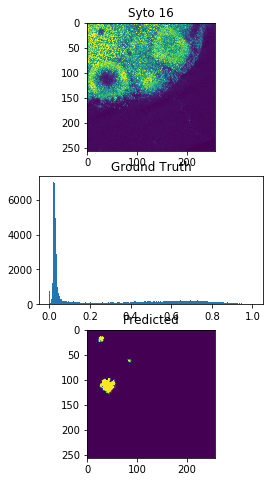

In [620]:
x, _ = next(iter(dataloader_train))
img = x[:, 0].unsqueeze(1).to(device)
seg = x[:, 1].unsqueeze(1)
seg = (seg > 0).type(torch.float).to(device)
output = model(img)

img = img.detach().cpu().numpy()
seg = seg.detach().cpu().numpy()
output = output.detach().cpu().numpy()

img = img[0, 0]
seg = seg[0, 0]
output = output[0, 0]

plt.figure(figsize=(4, 8))
plt.subplot(311)
plt.imshow(img, clim=[0, 1])
plt.title('Syto 16')
plt.subplot(312)
# plt.imshow(seg, clim=[0, 1])
plt.hist(img.ravel(), bins=256, range=(0, 1))
plt.title('Ground Truth')
plt.subplot(313)
plt.imshow(output, clim=[0, 0.5])
plt.title('Predicted')
plt.show()

# print(seg.max(), img.max())

In [621]:
torch.save(model.state_dict(), os.path.join(working_dir, 'unet_d35_d60_200.pt'))